<a href="https://colab.research.google.com/github/ryu622/gnn-counterattack-xai-v2/blob/main/GNN_CounterAttack_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GNNのカウンターアタックの論文のデータを用いて、CrystalConvではなくGATを用いてやってみる。

In [ ]:
from google.colab import drive
import os

# Google Driveをマウント
drive.mount('/content/drive')



# ファイルのパスを定義 (RAW_DATAフォルダ内の women.pkl)
file_path = '/content/drive/MyDrive/GNN_Football_Analysis/Raw_Data/women.pkl'

print(f"データファイルパス: {file_path}")

# ファイルが存在するか確認（任意）
if os.path.exists(file_path):
    print("ファイルは存在します。ロードに進めます。")
else:
    print("エラー: ファイルが見つかりません。パスを確認してください。")

Mounted at /content/drive
データファイルパス: /content/drive/MyDrive/GNN_Football_Analysis/Raw_Data/women.pkl
ファイルは存在します。ロードに進めます。


In [ ]:
!pip install ipywidgets matplotlib pandas scikit-learn spektral tensorflow progressbar ml-insights

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 38.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.4 MB/s eta 0:00:00
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12065 sha256=817e7258db89e30d541e33531811184bbf91c20659de0457238742dbc18fb428
  Stored in directory: /root/.cache/pip/wheels/a5/4d/c7/f3cf0f75c746c219090060131fe00f1523cc2c5484991f4030
  Created wheel for splinecalib: filename=splinecalib-0.0.13-cp312-cp312-linux_x86_64.whl size=2788453 sha256=f1c305eece9c59e7ca10fb0b7a04ed25d32f822e36e04d5d4b1b161fa51f2e34
  Stored in directory: /root/.cache/pip/wheels/92/f7/36/a3a01ad624e2432814cb5342c1c4b2d3d8b0c8542c5dca267e
Successfully built progressbar splinecal

In [ ]:
!pip install torch torchvision torchaudio
!pip install torch_geometric numpy pandas scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.4 MB/s eta 0:00:00


In [ ]:
from ipywidgets import Checkbox, Dropdown, Accordion, VBox
import sklearn.metrics as metrics
from sklearn.calibration import calibration_curve
from spektral.data import Dataset, Graph, DisjointLoader
from spektral.layers import CrystalConv, GlobalAvgPool
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

import copy
import logging
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import random
import sys
import tensorflow as tf
import requests
import progressbar
from os.path import isfile
import time

# Setting up the logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
stdout_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(stdout_handler)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# PyGのインポートも確認
from torch_geometric.nn import GATConv, global_mean_pool

In [ ]:
# データのロード
logger.info(f"Opening {file_path}...")
try:
    with open(file_path, 'rb') as handle:
        og_data = pickle.load(handle)

    logger.info("データが正常にロードされ、変数 'og_data' に格納されました。")
    print("-" * 30)
    print(f"ロードされたデータのキー: {og_data.keys()}")

except FileNotFoundError:
    logger.error(f"エラー: ファイル '{file_path}' が見つかりません。パスを確認してください。")
except Exception as e:
    logger.error(f"データのロード中にエラーが発生しました: {e}")

Opening /content/drive/MyDrive/GNN_Football_Analysis/Raw_Data/women.pkl...


INFO:__main__:Opening /content/drive/MyDrive/GNN_Football_Analysis/Raw_Data/women.pkl...


データが正常にロードされ、変数 'og_data' に格納されました。


INFO:__main__:データが正常にロードされ、変数 'og_data' に格納されました。


------------------------------
ロードされたデータのキー: dict_keys(['delaunay', 'normal', 'dense', 'dense_ap', 'dense_dp', 'binary'])


In [ ]:
import numpy as np
# SpektralとTensorFlowは既にインストール済みと仮定

# ipywidgetsのモックオブジェクトを定義（ウィジェットを使わないための代替手段）
class MockDropdown:
    def __init__(self, value):
        self.value = value
class MockVBox:
    def __init__(self, children):
        self.children = children
class Checkbox:
    def __init__(self, value, description):
        self.value = value
        self.description = description

# 2.2 隣接行列の選択: 'normal' を選択
adj_matrix_value = 'normal'
adj_matrix = MockDropdown(adj_matrix_value)


# 2.3 エッジ特徴量の選択: すべてにチェックを入れる
edge_f_box_children = [
    Checkbox(value=True, description='Player Distance'),
    Checkbox(value=True, description='Speed Difference'),
    Checkbox(value=True, description='Positional Sine angle'),
    Checkbox(value=True, description='Positional Cosine angle'),
    Checkbox(value=True, description='Velocity Sine angle'),
    Checkbox(value=True, description='Velocity Cosine angle'),
]
edge_f_box = MockVBox(edge_f_box_children)


# 2.4 ノード特徴量の選択: すべてにチェックを入れる
node_f_box_children = [
    Checkbox(value=True, description='x coordinate'),
    Checkbox(value=True, description='y coordinate'),
    Checkbox(value=True, description='vX'),
    Checkbox(value=True, description='vY'),
    Checkbox(value=True, description='Velocity'),
    Checkbox(value=True, description='Velocity Angle'),
    Checkbox(value=True, description='Distance to Goal'),
    Checkbox(value=True, description='Angle with Goal'),
    Checkbox(value=True, description='Distance to Ball'),
    Checkbox(value=True, description='Angle with Ball'),
    Checkbox(value=True, description='Attacking Team Flag'),
    Checkbox(value=True, description='Potential Receiver'),
]
node_f_box = MockVBox(node_f_box_children)

print(f"隣接行列: '{adj_matrix.value}' に設定")
print("エッジ特徴量とノード特徴量はすべて選択されました。")

隣接行列: 'normal' に設定
エッジ特徴量とノード特徴量はすべて選択されました。


In [ ]:
import copy
from spektral.data import Dataset, Graph, DisjointLoader
import tensorflow as tf

# セクション 2.6: filter_features 関数の定義と実行 (修正済み)
def filter_features(data, gender=None):
    """
    データから選択されたノード特徴量とエッジ特徴量のみをフィルタリングする。
    """
    # 選択された特徴量のインデックスを取得
    edge_feature_idxs = [idx for idx, x in enumerate(edge_f_box.children) if x.value]
    node_feature_idxs = [idx for idx, x in enumerate(node_f_box.children) if x.value]

    # ノード特徴量の名前をグローバル変数として取得 (セクション 5 のために必要)
    global node_features
    node_features = [x.description for x in node_f_box.children if x.value]

    if not any(edge_feature_idxs) and not any(node_feature_idxs):
        print("\nCannot have zero edge features and zero node features. Defaulting to the previous configuration.")
    else:
        mat_type = adj_matrix.value

        # データのフィルタリングを適用 (ここを修正: 'normal_e' -> 'e', 'normal_x' -> 'x')
        # 隣接行列のデータセット内にある 'e' と 'x' にアクセス
        data[mat_type]['e'] = [x[:, edge_feature_idxs] for x in data[mat_type]['e']]
        data[mat_type]['x'] = [x[:, node_feature_idxs] for x in data[mat_type]['x']]

    return data

# データのフィルタリングを実行
data = filter_features(og_data.copy())
print("特徴量のフィルタリングが完了しました。")


# セクション 2.7: CounterDataset クラスの定義とデータセットのロード (修正済み)
class CounterDataset(Dataset):
    """
    SpektralのDatasetクラスを継承し、ノード特徴量、エッジ特徴量、隣接行列を含むGraphオブジェクトのリストを返す。
    """
    def __init__(self, **kwargs):
        self.data = kwargs['data']
        self.matrix_type = kwargs['matrix_type']
        super().__init__(**kwargs)

    def read(self):
        logger.info("Loading Pass Dataset.")
        data_mat = self.data[self.matrix_type]

        # Print Graph information (ここも修正: 'normal_x' -> 'x', 'normal_e' -> 'e', 'normal_a' -> 'a')
        logger.info(
            f"""node_features (x): {data_mat['x'][0].shape}
             \n adj_matrix (a): {data_mat['a'][0].shape}
             \n edge_features (e): {data_mat['e'][0].shape}
             """
        )

        # Graphオブジェクトを生成 (ここも修正: 'normal_x' -> 'x', 'normal_a' -> 'a', 'normal_e' -> 'e')
        return [
            Graph(x=x, a=a, e=e, y=y) for x, a, e, y in zip(
                data_mat['x'], data_mat['a'], data_mat['e'], self.data['binary']
            )
        ]

# データセットのロードとGraphオブジェクトへの変換を実行
dataset = CounterDataset(data = data, matrix_type = adj_matrix.value)
print(f"データセットのロードと変換が完了しました。全サンプル数: {len(dataset)}")

特徴量のフィルタリングが完了しました。
Loading Pass Dataset.


INFO:__main__:Loading Pass Dataset.


node_features (x): (23, 12)
             
 adj_matrix (a): (23, 23)
             
 edge_features (e): (287, 6)
             


INFO:__main__:node_features (x): (23, 12)
             
 adj_matrix (a): (23, 23)
             
 edge_features (e): (287, 6)
             


データセットのロードと変換が完了しました。全サンプル数: 4348


互換性の都合上Pytorchへ書き換え

In [ ]:
import torch
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.utils import dense_to_sparse # 隣接行列をedge_indexに変換
import numpy as np
from tqdm import tqdm

# 以前のデータロードで得た 'data' (フィルタリング済み) を使用します

# PyGデータセットの定義 (修正版)

class PyG_CounterDataset(Dataset):
    def __init__(self, data, matrix_type, root=None, transform=None, pre_transform=None):
        self.raw_data = data
        self.matrix_type = matrix_type
        self._data_list = self.process_data()
        super().__init__(root, transform, pre_transform)

    def process_data(self):
        data_mat = self.raw_data[self.matrix_type]
        data_list = []

        # NumPy配列のリストをPyG Dataオブジェクトのリストに変換
        for x_np, a_np, e_np, y_np in tqdm(zip(
            data_mat['x'], data_mat['a'], data_mat['e'], self.raw_data['binary']
        ), total=len(data_mat['x']), desc="Converting to PyG Data"):

            try:
                # 破損チェック 1: ノード特徴量が空ではないか確認
                if x_np.shape[0] == 0:
                    continue # ノードがなければスキップ

                # 疎行列の修正: SciPyの疎行列を密行列に変換
                if hasattr(a_np, 'todense'):
                    a_np = a_np.todense()

                # テンソルへの変換
                x = torch.tensor(x_np, dtype=torch.float)
                a = torch.tensor(a_np, dtype=torch.float)
                e = torch.tensor(e_np, dtype=torch.float)
                y = torch.tensor(y_np, dtype=torch.float).view(-1, 1)

                # 隣接行列 (A) をエッジインデックス (edge_index) に変換
                edge_index, _ = dense_to_sparse(a)

                # 破損チェック 2: エッジがない場合はスキップ (GNN層は通常エッジを期待するため)
                if edge_index.numel() == 0:
                     continue

                # エッジ特徴量の整合性チェック
                if e.size(0) != edge_index.size(1):
                    edge_attr = None
                else:
                    edge_attr = e

                data_list.append(Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y))

            except Exception as e:
                # 変換中に予期せぬエラーが発生した場合も、そのサンプルをスキップし、ログ出力
                # print(f"破損したサンプルをスキップしました: {e}")
                continue # 続行

        return data_list

    def len(self):
        return len(self._data_list)

    def get(self, idx):
        return self._data_list[idx]

# データセットのロードと変換を再実行
dataset_pyg = PyG_CounterDataset(data=data, matrix_type='normal')
print(f"PyTorch Geometricデータセットの変換が完了しました。有効なサンプル数: {len(dataset_pyg)}")

Converting to PyG Data: 100%|██████████| 4348/4348 [00:00<00:00, 7503.60it/s]

PyTorch Geometricデータセットの変換が完了しました。有効なサンプル数: 4348


以上でデータの準備完了

In [ ]:
#ハイパーパラメータとデータローダーの準備

# 3.1 Configurations
learning_rate = 1e-3  # 学習率
epochs = 50          # 訓練エポック数 (最初は少なめに設定)
batch_size = 32      # バッチサイズ (元の16からGPU用に32に変更)
channels = 32        # GNN隠れ層の出力次元 (元の128から32に変更し、計算負荷を軽減)
layers = 3           # CrystalConv/GATConvの層の数
ATTN_HEADS = 4       # GATモデルで使用するアテンションヘッド数

# 3.2 Parameters and DataLoader Setup
# データセットのメタ情報を取得 (前のステップで計算済み)
N = max(g.n_nodes for g in dataset) # 最大ノード数 (23)
F = dataset.n_node_features         # ノード特徴量の次元 (12)
S = dataset.n_edge_features         # エッジ特徴量の次元 (6)
n_out = dataset.n_labels            # ターゲットの次元 (1)
n = len(dataset)                    # サンプル数 (4348)

# 訓練/テスト分割 (SpektralのDisjointLoaderで使用するインデックスを生成)
# データセットの分割比率: 訓練(70%)、テスト(30%)
split_tr = int(0.7 * n)
idxs = np.random.RandomState(seed=42).permutation(n)
idx_tr, idx_te = np.split(idxs, [split_tr])

dataset_tr = dataset[idx_tr]
dataset_te = dataset[idx_te]

# DataLoaderの構築 (SpektralのDisjointLoaderを使用)
# DisjointLoaderは、GNNのバッチ処理に適した形式にデータを自動で結合・分割します
loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs)
loader_te = DisjointLoader(dataset_te, batch_size=batch_size, epochs=1, shuffle=False)

logger.info(f"全サンプル数: {n}")
logger.info(f"訓練サンプル数: {len(dataset_tr)}")
logger.info(f"テストサンプル数: {len(dataset_te)}")
print("DataLoaderの構築が完了しました。")

全サンプル数: 4348


INFO:__main__:全サンプル数: 4348


訓練サンプル数: 3043


INFO:__main__:訓練サンプル数: 3043


テストサンプル数: 1305


INFO:__main__:テストサンプル数: 1305


DataLoaderの構築が完了しました。


In [ ]:
#GATモデルの定義
'''from spektral.layers import GATConv, GlobalAvgPool # GATConvをインポート
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC

# 3.3 Build GNN Model
class GNN(Model):'''

    #GATConvを使用してGraph Neural Networkを構築します。

    '''def __init__(self, n_layers, channels, n_out, attn_heads):
        super().__init__()

        # GATConv層の定義
        self.conv1 = GATConv(channels, attn_heads=attn_heads, activation='elu')

        # 後続のGAT層
        self.convs = []
        for _ in range(1, n_layers):
            self.convs.append(
                GATConv(channels, attn_heads=attn_heads, activation='elu')
            )

        self.pool = GlobalAvgPool() # グラフ全体を集約

        # 全結合層 (MLP)
        self.dense1 = Dense(channels, activation="relu")
        self.dropout = Dropout(0.5)
        self.dense2 = Dense(channels, activation="relu")
        self.dense3 = Dense(n_out, activation="sigmoid") # 最終出力層

    def call(self, inputs):'''
        '''
        #順伝播の実行。GATConvにはノード特徴量(x)と隣接行列(a)のみを渡す。
        '''
        # inputs: [x, a, e, i] を受け取るが、e (エッジ特徴量) はここでは無視される
        '''x, a, e, i = inputs

        # GATConv層の実行: [x, a] の2つだけを渡す！(修正箇所)
        x = self.conv1([x, a])

        for conv in self.convs:
            # 2層目以降も同様に [x, a] の2つだけを渡す
            x = conv([x, a])

        x = self.pool([x, i]) # プーリングにはノード特徴量とバッチインデックスを使用

        # MLP実行
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        x = self.dropout(x)
        return self.dense3(x)

# モデルのインスタンス化
# ATTN_HEADS, channels, layers, n_out は前のセルで定義された変数を使用
model = GNN(n_layers=layers, channels=channels, n_out=n_out, attn_heads=ATTN_HEADS)

# オプティマイザと損失関数の設定
optimizer = Adam(learning_rate=learning_rate)
loss_fn = BinaryCrossentropy()

logger.info("GATモデルの構築と設定が完了しました。")

ライブラリの依存関係の都合上、パイトーチへ書き換え
'''

IndentationError: unexpected indent (ipython-input-2087226253.py, line 11)

In [ ]:
#訓練の実行
'''
# 3.4 Fit Model
@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# 訓練ループの実行
step = loss = 0

print("GATモデルの訓練を開始します...")
for epoch in range(epochs):
    print(f"--- Epoch {epoch + 1}/{epochs} ---")

    # DataLoaderはイテレーション数が設定されているため、次のエポックへ進むまでバッチを生成し続けます
    for batch in loader_tr:
        step += 1
        loss += train_step(*batch)

        # 1エポック完了時の処理
        if step == loader_tr.steps_per_epoch:
            print("Loss: {:.4f}".format(loss.numpy() / loader_tr.steps_per_epoch))
            step = 0
            loss = 0
            break # DisjointLoaderはエポックごとに自動で停止しますが、念のため

print("GATモデルの訓練が完了しました。")'''

In [ ]:
#モデルの定義
# --- 4. GATモデルの再構築 (セクション 3.3の代替) ---
# ハイパーパラメータの設定 (前のセルで定義された変数を使用)
CHANNELS = 32
LAYERS = 3
ATTN_HEADS = 4
N_OUT = 1

class PyG_GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, num_heads, out_channels):
        super(PyG_GNN, self).__init__()

        self.conv1 = GATConv(in_channels, hidden_channels,
                             heads=num_heads, dropout=0.5, concat=True)

        self.convs = nn.ModuleList()
        for _ in range(num_layers - 1):
            self.convs.append(
                GATConv(hidden_channels * num_heads, hidden_channels,
                        heads=num_heads, dropout=0.5, concat=True)
            )

        # 最終GAT層: 出力次元を揃えるために heads=1, concat=False
        self.conv_out = GATConv(hidden_channels * num_heads, hidden_channels,
                                heads=1, dropout=0.5, concat=False)

        # MLP層
        self.dense1 = nn.Linear(hidden_channels, hidden_channels)
        self.dense_out = nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        # PyGでは Dataオブジェクトから x, edge_index, batch を取得
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # GAT層の実行
        x = F.elu(self.conv1(x, edge_index))
        for conv in self.convs:
            x = F.elu(conv(x, edge_index))
        x = F.elu(self.conv_out(x, edge_index))

        # Global Pooling (グラフ分類のため)
        x = global_mean_pool(x, batch)

        # MLP実行
        x = F.relu(self.dense1(x))
        x = F.dropout(x, p=0.5, training=self.training)

        # 最終出力 (シグモイド)
        return torch.sigmoid(self.dense_out(x))

# モデルのインスタンス化
model_pyg = PyG_GNN(
    in_channels=dataset_pyg.num_node_features,
    hidden_channels=CHANNELS,
    num_layers=LAYERS,
    num_heads=ATTN_HEADS,
    out_channels=N_OUT
)
print("PyTorch GATモデルの再構築完了。")

PyTorch GATモデルの再構築完了。


In [ ]:
# DataLoaderの準備 (有効なサンプルリストを使用)
final_data_list = dataset_pyg._data_list # 破損していない有効なデータリスト
indices = np.arange(len(final_data_list))

# 訓練/テスト分割 (30% テスト)
idx_tr, idx_te = train_test_split(indices, test_size=0.3, random_state=42)

dataset_tr_pyg = [final_data_list[i] for i in idx_tr]
dataset_te_pyg = [final_data_list[i] for i in idx_te]

BATCH_SIZE = 32
loader_tr_pyg = PyGDataLoader(dataset_tr_pyg, batch_size=BATCH_SIZE, shuffle=True)
loader_te_pyg = PyGDataLoader(dataset_te_pyg, batch_size=BATCH_SIZE, shuffle=False)

# オプティマイザと損失関数の設定
optimizer_pyg = torch.optim.Adam(model_pyg.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()

In [ ]:
#実行

from torch_geometric.loader import DataLoader as PyGDataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

# --- 5. 訓練ループの実行 ---
LEARNING_RATE = 1e-3
EPOCHS = 50

# 訓練関数の定義
def train_pyg(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

# メイン訓練ループの実行
print("\n PyTorch GATモデルの訓練を開始します...")
for epoch in range(1, EPOCHS + 1):
    loss = train_pyg(model_pyg, loader_tr_pyg, optimizer_pyg, criterion)
    print(f"--- Epoch {epoch}/{EPOCHS} --- Loss: {loss:.4f}")

print("PyTorch GATモデルの訓練が完了しました。")


 PyTorch GATモデルの訓練を開始します...
--- Epoch 1/50 --- Loss: 0.6862
--- Epoch 2/50 --- Loss: 0.6689
--- Epoch 3/50 --- Loss: 0.6587
--- Epoch 4/50 --- Loss: 0.6537
--- Epoch 5/50 --- Loss: 0.6479
--- Epoch 6/50 --- Loss: 0.6484
--- Epoch 7/50 --- Loss: 0.6445
--- Epoch 8/50 --- Loss: 0.6478
--- Epoch 9/50 --- Loss: 0.6402
--- Epoch 10/50 --- Loss: 0.6431
--- Epoch 11/50 --- Loss: 0.6395
--- Epoch 12/50 --- Loss: 0.6386
--- Epoch 13/50 --- Loss: 0.6393
--- Epoch 14/50 --- Loss: 0.6392
--- Epoch 15/50 --- Loss: 0.6317
--- Epoch 16/50 --- Loss: 0.6370
--- Epoch 17/50 --- Loss: 0.6354
--- Epoch 18/50 --- Loss: 0.6382
--- Epoch 19/50 --- Loss: 0.6359
--- Epoch 20/50 --- Loss: 0.6321
--- Epoch 21/50 --- Loss: 0.6338
--- Epoch 22/50 --- Loss: 0.6333
--- Epoch 23/50 --- Loss: 0.6306
--- Epoch 24/50 --- Loss: 0.6305
--- Epoch 25/50 --- Loss: 0.6329
--- Epoch 26/50 --- Loss: 0.6278
--- Epoch 27/50 --- Loss: 0.6299
--- Epoch 28/50 --- Loss: 0.6267
--- Epoch 29/50 --- Loss: 0.6304
--- Epoch 30/50 --- Los

In [ ]:
#評価
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np


#評価関数の定義
def evaluate_pyg(model, loader):
    """
    テストデータローダーを使用してモデルを評価し、AUCとAccuracyを計算する。
    """
    # 1. モデルを評価モードに設定
    model.eval()

    all_preds = []
    all_labels = []

    # 2. 勾配計算を無効化 (推論時のメモリ効率化)
    with torch.no_grad():
        for data in loader:
            # 順伝播
            out = model(data)

            # 予測確率と正解ラベルを収集
            all_preds.append(out.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    # 3. すべてのバッチの結果を結合
    preds = np.concatenate(all_preds).flatten()
    labels = np.concatenate(all_labels).flatten()

    # 4. AUC (ROC曲線下面積) の計算
    try:
        # AUCは確率値 (0.0～1.0) を入力とする
        auc = roc_auc_score(labels, preds)
    except ValueError:
        # テストセットに片方のクラスしかない場合、AUCは計算できない
        auc = np.nan
        print("Warning: テストセットに単一クラスのみ含まれるため、AUCは未定義です。")

    # 5. Accuracy (正答率) の計算
    # 予測確率を0.5を閾値として二値化
    predicted_classes = (preds > 0.5).astype(int)
    accuracy = accuracy_score(labels, predicted_classes)

    return auc, accuracy

In [ ]:
# 訓練ループの後に実行

# 以前のデータ分割処理で得た、有効なデータリスト
final_data_list = dataset_pyg._data_list

# テストデータリストからNoneを明示的に除去する（安全策）
dataset_te_pyg_clean = [data for data in dataset_te_pyg if data is not None]

# DataLoaderを再構築 (念のため、エラーを引き起こした可能性のある古いローダーを使わない)
# BATCH_SIZEは前のセルで定義済み
loader_te_pyg_clean = PyGDataLoader(dataset_te_pyg_clean, batch_size=BATCH_SIZE, shuffle=False)

print(f"クリーンなテストサンプル数: {len(dataset_te_pyg_clean)}")

クリーンなテストサンプル数: 1304


In [ ]:
# 評価の実行

# 評価の実行
auc_te, acc_te = evaluate_pyg(model_pyg, loader_te_pyg_clean)

print(f"\n--- 最終テスト結果 (PyTorch GAT) ---")
print(f"Test AUC: {auc_te:.4f}")
print(f"Test Accuracy: {acc_te:.4f}")


--- 最終テスト結果 (PyTorch GAT) ---
Test AUC: 0.6990
Test Accuracy: 0.6518


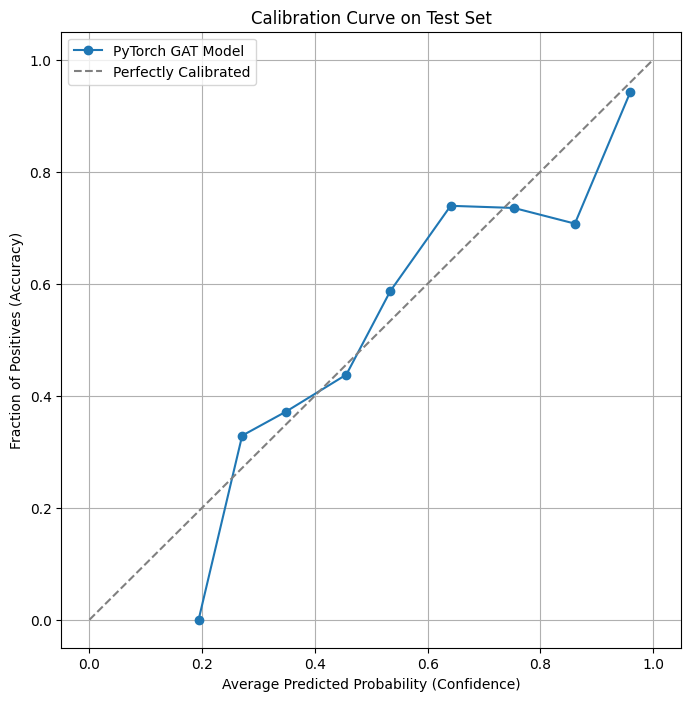

キャリブレーション曲線の描画が完了しました。


In [ ]:
#キャリブレーション
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# --- キャリブレーションデータの取得 ---
def get_calibration_data(model, loader, n_bins=10):
    """モデルの予測確率と真のラベルを取得し、キャリブレーション曲線のデータを計算する"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            out = model(data)
            all_preds.append(out.cpu().numpy())
            all_labels.append(data.y.cpu().numpy())

    preds = np.concatenate(all_preds).flatten()
    labels = np.concatenate(all_labels).flatten()

    # scikit-learnのcalibration_curveを使用してデータを計算
    # prob_true: 各ビンの実際の正答率 (y軸)
    # prob_pred: 各ビンの平均予測確率 (x軸)
    prob_true, prob_pred = calibration_curve(
        y_true=labels,
        y_prob=preds,
        n_bins=n_bins,
        strategy='uniform' # 均一な幅のビンを使用
    )

    return prob_true, prob_pred, preds, labels

# --- 実行と描画 ---
prob_true, prob_pred, preds_te, labels_te = get_calibration_data(model_pyg, loader_te_pyg_clean)

plt.figure(figsize=(8, 8))
# モデルのキャリブレーション曲線
plt.plot(prob_pred, prob_true, marker='o', label='PyTorch GAT Model')
# 理想的なキャリブレーション (対角線)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

plt.xlabel('Average Predicted Probability (Confidence)')
plt.ylabel('Fraction of Positives (Accuracy)')
plt.title('Calibration Curve on Test Set')
plt.legend()
plt.grid(True)
plt.show()

print("キャリブレーション曲線の描画が完了しました。")
# 理想的な対角線に近ければ近いほど、モデルの予測は「正直」であると評価できます。


--- 特徴量重要度 (AUC低下量) ---
[Distance to Goal    ] : 0.05168
[Angle with Goal     ] : 0.04735
[vX                  ] : 0.03422
[x coordinate        ] : 0.01716
[Attacking Team Flag ] : 0.01091
[Distance to Ball    ] : 0.01047
[y coordinate        ] : 0.00746
[Potential Receiver  ] : 0.00695
[Velocity            ] : 0.00540
[vY                  ] : 0.00466
[Angle with Ball     ] : 0.00383
[Velocity Angle      ] : 0.00169


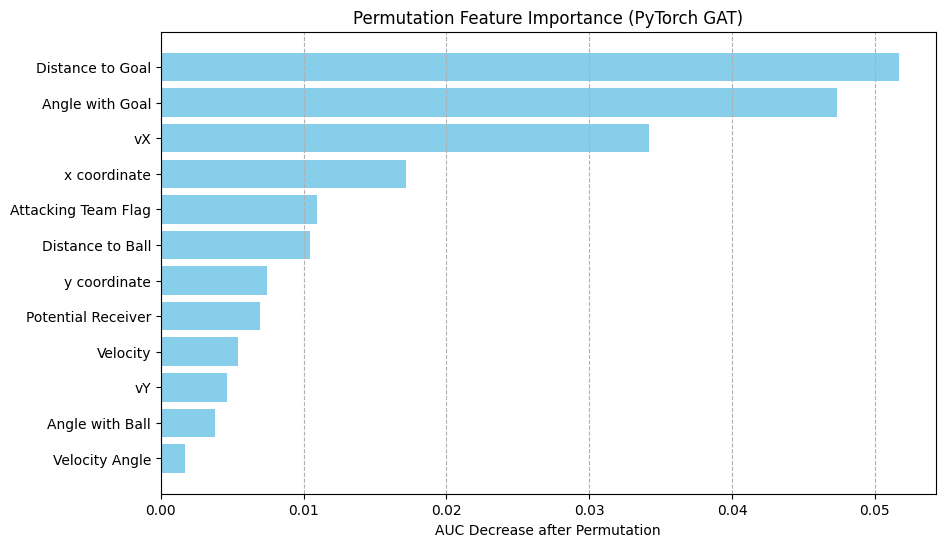

特徴量重要度の計算と描画が完了しました。


In [ ]:
#PFI
# --- 特徴量重要度の計算 ---
# 特徴量の名前は filter_features 関数で定義されたグローバル変数 node_features を使用します
global node_features # 以前のステップで定義されています

def calculate_permutation_importance(model, loader, features_list, n_repeats=5):
    """テストデータセット上で、各特徴量のパーミュテーション重要度 (AUCの低下) を計算する"""

    # 1. ベースラインAUCの計算
    auc, _ = evaluate_pyg(model, loader)
    baseline_auc = auc

    importance = {}

    # 2. 各特徴量に対して重要度を測定
    for idx, feature_name in enumerate(features_list):
        auc_decreases = []

        for _ in range(n_repeats):
            # 2.1. テストローダー内の全グラフをパーミュテーション処理
            permuted_data_list = []
            for batch_data in loader:
                # バッチ内のノード特徴量 x のコピーを作成
                x_permuted = batch_data.x.clone()

                # 特定の特徴量列 (idx) をランダムに入れ替え (パーミュテーション)
                # バッチ全体でランダムに行うのが一般的
                perm_indices = torch.randperm(x_permuted.size(0))
                x_permuted[:, idx] = x_permuted[perm_indices, idx]

                # 新しいxでデータオブジェクトを再構築 (バッチ構造を維持)
                permuted_batch = batch_data.clone()
                permuted_batch.x = x_permuted
                permuted_data_list.append(permuted_batch)

            # 2.2. パーミュテーション後のAUCを評価
            # Note: PyGDataLoaderはリストを受け取るため、ここで新しいDataLoaderを一時的に使用します
            permuted_loader = PyGDataLoader(permuted_data_list, batch_size=loader.batch_size, shuffle=False)
            permuted_auc, _ = evaluate_pyg(model, permuted_loader)
            auc_decreases.append(baseline_auc - permuted_auc)

        # 2.3. 平均低下量を格納
        importance[feature_name] = np.mean(auc_decreases)

    return importance

# --- 実行と描画 ---

# 注意: n_repeatsが多いほど精度が上がりますが、計算時間がかかります。
importance_results = calculate_permutation_importance(model_pyg, loader_te_pyg_clean, node_features, n_repeats=1) # まずは n_repeats=1 で試します

# 結果をソートして表示
sorted_importance = sorted(importance_results.items(), key=lambda item: item[1], reverse=True)

print("\n--- 特徴量重要度 (AUC低下量) ---")
for feature, decrease in sorted_importance:
    print(f"[{feature: <20}] : {decrease:.5f}")

# 棒グラフで視覚化
features = [item[0] for item in sorted_importance]
decreases = [item[1] for item in sorted_importance]

plt.figure(figsize=(10, 6))
plt.barh(features, decreases, color='skyblue')
plt.xlabel('AUC Decrease after Permutation')
plt.title('Permutation Feature Importance (PyTorch GAT)')
plt.gca().invert_yaxis() # 最も重要な特徴量を上に表示
plt.grid(axis='x', linestyle='--')
plt.show()

print("特徴量重要度の計算と描画が完了しました。")

精度は元論文に及んでいないが、ある程度モデルとして使える精度が出た。また、PFIでも元論文と完全に一致はしていないが重要視した特徴量はほぼ一致した。
このコードではアテンションの可視化ができないので、別ファイルで可視化ありのコードを実行する。